In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
model_path = "/content/drive/My Drive/BERT_Sarcasm_Model"

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Set model to eval mode (not strictly required for CPU inference,
# but good practice if no further training)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

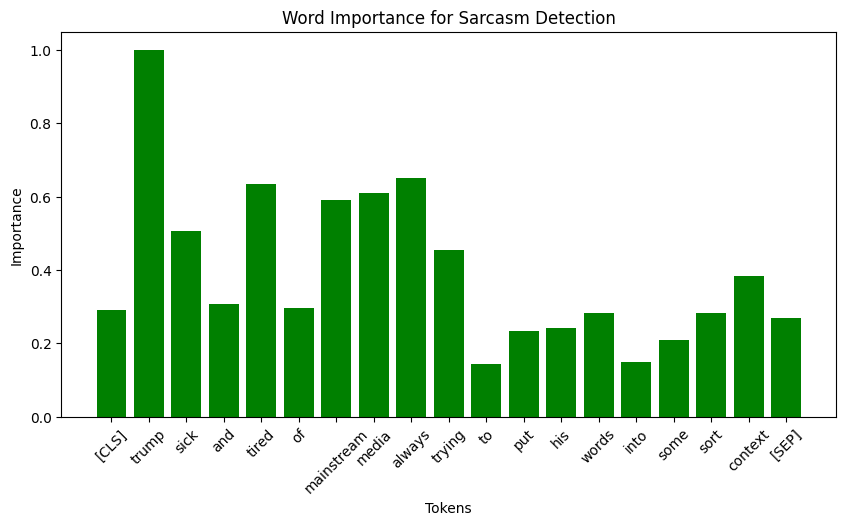

In [5]:
#words graph

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/My Drive/BERT_Sarcasm_Model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

model.train()

def forward_pass_with_custom_embeddings(model, input_embeddings, attention_mask=None):
    """
    This manually feeds custom input_embeddings into the BERT encoder,
    then passes the encoder output to the classification head.
    """
    # 2.1) Pass embeddings into BERT encoder
    encoder_outputs = model.bert(
        inputs_embeds=input_embeddings,
        attention_mask=attention_mask,
        token_type_ids=None
    )
    # encoder_outputs is a tuple: (last_hidden_state, pooler_output, hidden_states, attentions)
    sequence_output = encoder_outputs[0]  # [batch_size, seq_len, hidden_size]
    pooled_output = encoder_outputs[1]    # [batch_size, hidden_size]

    logits = model.classifier(pooled_output)
    return logits

sentence = "Trump Sick And Tired Of Mainstream Media Always Trying To Put His Words Into Some Sort Of Context"

inputs = tokenizer(sentence, return_tensors="pt")

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

embedding_layer = model.bert.embeddings.word_embeddings  # Embedding matrix
# shape: [batch_size=1, sequence_length, hidden_dim]
input_embeddings = embedding_layer(input_ids)
input_embeddings.requires_grad_()        # Ensure gradient tracking
input_embeddings.retain_grad()           # Retain gradient for visualization

logits = forward_pass_with_custom_embeddings(
    model=model,
    input_embeddings=input_embeddings,
    attention_mask=attention_mask
)

model.zero_grad()  # Clear previous gradients
predicted_class = logits.argmax(dim=-1).item()
logits[:, predicted_class].backward()  # Compute gradients wrt predicted class

if input_embeddings.grad is None:
    raise RuntimeError("Gradients were not computed on embeddings!")


gradients = input_embeddings.grad.abs().sum(dim=-1).squeeze().cpu().numpy()
gradients /= gradients.max()  # Normalize importance to [0..1]

tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

plt.figure(figsize=(10, 5))
plt.bar(tokens, gradients, color="green")
plt.xlabel("Tokens")
plt.ylabel("Importance")
plt.title("Word Importance for Sarcasm Detection")
plt.xticks(rotation=45)
plt.show()


In [1]:

!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [8]:
import gradio as gr
def predict_sarcasm(text):
    """
    Takes a raw string (text), uses the BERT tokenizer & model to predict
    whether the sentence is sarcastic or not.
    """
    # 1) Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # 2) Inference (disable gradient computation for speed)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # 3) Get predicted class: 0 -> Not Sarcastic, 1 -> Sarcastic
    predicted_class = torch.argmax(logits, dim=-1).item()

    # 4) Return a user-friendly response
    if predicted_class == 1:
        return "Sarcasm Detected! 🤨"
    else:
        return "No Sarcasm 🙂"


In [9]:
iface = gr.Interface(
    fn=predict_sarcasm,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
    outputs="text",
    title="Sarcasm Detector",
    description="Enter a sentence and check if it's sarcastic!",
    theme="default"
)


In [10]:
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://755bec9946d814c4f7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
